# Jellium
[?](?)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv

from hnc.hnc.PIE import Plasma_of_Ions_and_Electrons as PLASMA

from hnc.hnc.constants import *
from hnc.hnc.misc import n_from_rs, rs_from_n, P_Ideal_Fermi_Gas, E_Ideal_Fermi_Gas 

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
                
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}

</style>
""")


### Set Parameters in Paper and Plot

In [2]:
name = 'Jellium'
Z, A = 1,1 

Te_eV = 1 # eV
rs_AU = 1
rs_cm = rs_AU/cm_to_AU
ne_cc = n_from_rs(rs_cm)
ne_AU = n_from_rs(rs_AU)


#### Run Ornstein-Zernike Closure

In [3]:
P_hnc_to_bar = lambda P_hnc: (P_hnc/rs_AU**3) *  AU_to_bar 
P_hnc_to_Mbar = lambda P_hnc: 1e-6*P_hnc_to_bar(P_hnc)
E_hnc_to_eV   = lambda E_hnc: E_hnc/jellium.hnc.rho[0] * AU_to_eV

def get_jellium_P_Mbar(jellium_hnc):
    # jellium_hnc.h_r_matrix -= 1
    P_hnc = jellium_hnc.excess_pressure_matrix()
    # jellium_hnc.h_r_matrix += 1
    return P_hnc_to_Mbar(P_hnc)[0,0]


In [4]:
jellium_func = lambda Te_eV, ne_cc: PLASMA(1, 1, ne_cc, 1, Te_eV, Zbar=1, find_βuee=True,
                 βu_options = {'add_bridge':False,'bridge':'ocp', 'pseudopotential':False}, 
                 qsp_options= {'r_c':0,'which_Tij':'geometric'},
                 hnc_options= {'kappa_multiscale':10, 'R_max':20,'N_bins':1000, 
                               'h_max':2e2,'oz_method':'standard'},
                 hnc_solve_options={'alpha_Picard':0.5, 'num_iterations':1e4})

# Make Jellium PLASMA object
jellium = jellium_func(Te_eV, ne_cc)
jellium.run_jellium_hnc()
# Reset βvee
βvee_Pauli   = jellium.qsp.βv_Pauli(  jellium.jellium_hnc.r_array , jellium.qsp.Λee )
βvee_Pauli   = jellium.βP_ee
βvee_Deutsch = jellium.qsp.βv_Deutsch( jellium.qsp.Γee, jellium.jellium_hnc.r_array , jellium.qsp.Λee )
jellium.jellium_hnc.set_βu_matrix(np.array([[βvee_Pauli + βvee_Deutsch ]]))
jellium.jellium_hnc.HNC_solve(**jellium.hnc_solve_options)



Te_in_eV: 1.000
Ti_in_eV: 1.000


/home/zach/plasma/hnc/hnc/PIE.py:150: RuntimeWarning: overflow encountered in exp
  integrand = lambda t: t*np.sin(sin_arg*t)/(1+np.exp(t**2-η))
/home/zach/plasma/hnc/hnc/PIE.py:151: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  κ = 3*(2*self.qsp.Te*m_e) / (self.qsp.k_F**3 * r) *quad(integrand, 0, t_max)[0]
/home/zach/plasma/hnc/hnc/PIE.py:151: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  κ = 3*(2*self.qsp.Te*m_e) / (self.qsp.k_F**3 * r) *quad(integrand, 0, t_max)[0]


0: Initial condition Total Error: 9.851e-02
Exiting status 0, reverting to best index so far: 35
Final iter:36, Total Error: 9.637e-09
0: Initial condition Total Error: 8.061e-03
Exiting status 0, reverting to best index so far: 28
Final iter:29, Total Error: 9.504e-09


/home/zach/plasma/hnc/hnc/PIE.py:158: RuntimeWarning: overflow encountered in exp
  f_of_k = 1/(  1+np.exp((dense_hnc.k_array/self.qsp.ri)**2/(2*m_e*self.qsp.Te) - η) )


0

#### Pressures

In [5]:
print(P_hnc_to_Mbar(jellium.jellium_hnc.excess_pressure_matrix()))
jellium.jellium_hnc.βu_r_matrix[0,0] -= jellium.βP_ee
print(P_hnc_to_Mbar(jellium.jellium_hnc.excess_pressure_matrix()))
jellium.jellium_hnc.βu_r_matrix[0,0] += jellium.βP_ee
print(P_hnc_to_Mbar(jellium.jellium_hnc.excess_pressure_matrix()))

[[7445.35565179]]
[[6980.3930465]]
[[7445.35565179]]


In [6]:
P_Fermi_Mbar = 2/5 * jellium.qsp.E_F/(4/3*π*(jellium.qsp.ri)**3) * AU_to_bar/1e6

P_hnc_to_Mbar(jellium.jellium_hnc.ideal_pressure()),get_jellium_P_Mbar( jellium.jellium_hnc), P_Fermi_Mbar

(51.823981402874175, 7445.355651793744, 51.739302540025804)

##### Plot Radial Dsitribution Function

Missing colon in file '~/plasma/hnc/hnc_paper.mplstyle', line 45 ("text.latex.preamble = r'\\boldmath'")


(0.0, 5.0)

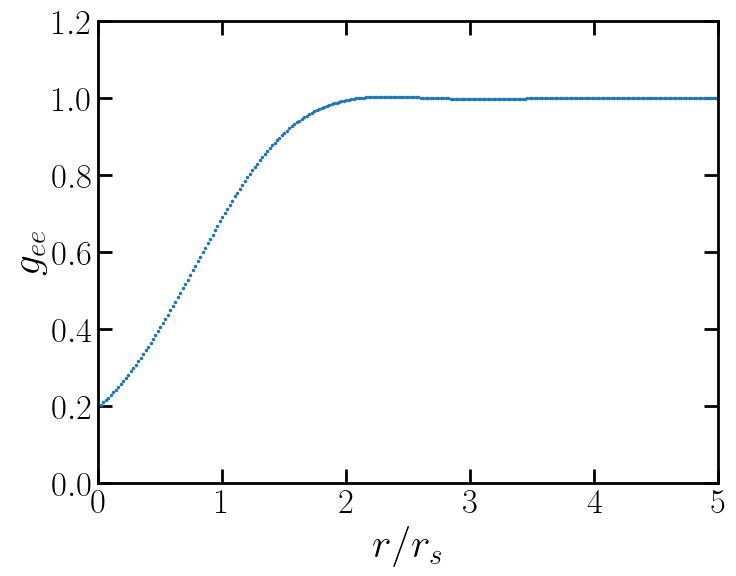

In [7]:
plt.style.use('~/plasma/hnc/hnc_paper.mplstyle')

fig, ax = plt.subplots()

ax.plot(jellium.jellium_hnc.r_array, jellium.jellium_hnc.h_r_matrix[0,0]+1,'.', label='Default Pauli')
# ax.plot(jellium.jellium_hnc.r_array, jellium.jellium_hnc.h_r_matrix[0,0]+1, label='Default Pauli')


ax.set_xlabel(r"$r/r_s$")
ax.set_ylabel(r"$g_{ee}$")

ax.set_ylim(0,1.2)
ax.set_xlim(0,5)

#### Plot βu

Missing colon in file '~/plasma/hnc/hnc_paper.mplstyle', line 45 ("text.latex.preamble = r'\\boldmath'")


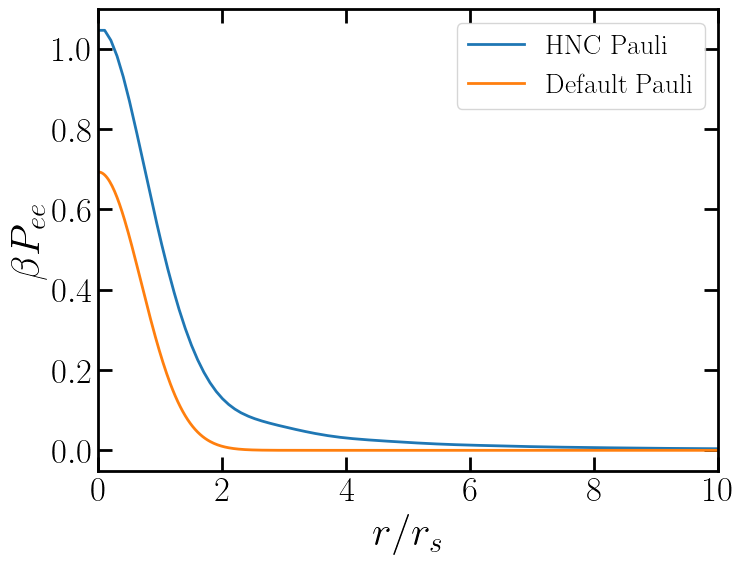

In [8]:
plt.style.use('~/plasma/hnc/hnc_paper.mplstyle')

fig, ax = plt.subplots()

ax.plot(jellium.jellium_hnc.r_array, jellium.βP_ee, label='HNC Pauli')
ax.plot(jellium.jellium_hnc.r_array, jellium.qsp.βv_Pauli(  jellium.jellium_hnc.r_array , jellium.qsp.Λee ), label='Default Pauli')

ax.set_xlabel(r"$r/r_s$")
ax.set_ylabel(r"$\beta P_{ee}$")

# ax.set_ylim(0,1.2)
ax.set_xlim(0,10)
ax.legend()

# New Thermodynamics

In [9]:
ε = 1e-4
jellium_1 = jellium_func(Te_eV*(1-ε), ne_cc)
jellium_1.run_jellium_hnc()
jellium_2 = jellium_func(Te_eV*(1+ε), ne_cc)
jellium_2.run_jellium_hnc()
dT = Te_eV*2*ε

d_βP_eV = -Te_eV**2*(jellium_2.βP_ee - jellium_1.βP_ee)/dT
d_βP_AU = d_βP_eV*eV_to_AU
d_β  = -Te_eV**2*( 1/jellium_2.jellium_hnc.Temp_matrix - 1/jellium_1.jellium_hnc.Temp_matrix)[0,0]/dT * eV_to_AU

Te_in_eV: 1.000
Ti_in_eV: 1.000


/home/zach/plasma/hnc/hnc/PIE.py:150: RuntimeWarning: overflow encountered in exp
  integrand = lambda t: t*np.sin(sin_arg*t)/(1+np.exp(t**2-η))
/home/zach/plasma/hnc/hnc/PIE.py:151: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  κ = 3*(2*self.qsp.Te*m_e) / (self.qsp.k_F**3 * r) *quad(integrand, 0, t_max)[0]
/home/zach/plasma/hnc/hnc/PIE.py:151: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  κ = 3*(2*self.qsp.Te*m_e) / (self.qsp.k_F**3 * r) *quad(integrand, 0, t_max)[0]
/home/zach/plasma/hnc/hnc/PIE.py:158: RuntimeWarning: overflow encountered in ex

0: Initial condition Total Error: 9.851e-02
Exiting status 0, reverting to best index so far: 35
Final iter:36, Total Error: 9.637e-09
Te_in_eV: 1.000
Ti_in_eV: 1.000



KeyboardInterrupt



In [ ]:
d_β*jellium.qsp.Te_c/jellium.qsp.Te

# Plot $\beta_c u_P$ vs $\frac{\partial \beta_c u_P}{\partial \beta}$

In [ ]:
plt.style.use('~/plasma/hnc/hnc_paper.mplstyle')

fig, ax = plt.subplots()

ax.plot(jellium.jellium_hnc.r_array, jellium.βP_ee, label='HNC Pauli')
ax.plot(jellium.jellium_hnc.r_array, d_βP_AU, label='New HNC Pauli')

ax.plot(jellium.jellium_hnc.r_array, jellium.qsp.βv_Pauli(  jellium.jellium_hnc.r_array , jellium.qsp.Λee ), label='Default Pauli')

ax.set_xlabel(r"$r/r_s$")
ax.set_ylabel(r"$\beta P_{ee}$")

# ax.set_ylim(0,1.2)
ax.set_xlim(0,10)
ax.legend()

In [ ]:
E_ideal_eV_func = lambda Te_eV, Ti_eV: E_Ideal_Fermi_Gas(Te_eV*eV_to_AU, ne_AU)*AU_to_eV + 3/2*Ti_eV

def excess_energy_density_matrix(plasma, d_βP ):
    g_matrix = plasma.jellium_hnc.h_r_matrix+1
    rho_matrix = plasma.jellium_hnc.rho[:,np.newaxis]*plasma.jellium_hnc.rho[np.newaxis,:]
    r = plasma.jellium_hnc.r_array[np.newaxis,np.newaxis,:]
    dr = plasma.jellium_hnc.del_r
    
    u_ex_matrix = np.sum(2*π*rho_matrix[:,:,np.newaxis]*d_βP*g_matrix*r**2*dr,axis=2)
    return u_ex_matrix

E_ideal_eV_func(Te_eV, Te_eV), E_hnc_to_eV( excess_energy_density_matrix(jellium, d_βP_AU)[0,0]), E_hnc_to_eV( excess_energy_density_matrix(jellium, jellium.βP_ee)[0,0])

In [ ]:
(3/2*1*jellium.jellium_hnc.Temp_list*AU_to_eV)[0]* np.array([d_β, 1])

In [ ]:
3/2 * jellium.qsp.Te*AU_to_eV

In [ ]:
jellium.qsp.Te_c/jellium.qsp.Te

# Change of Pauli Potential with Density
We should recover $\beta u_P \propto E_F$

In [10]:
jellium_func = lambda Te_eV, ne_cc: PLASMA(1, 1, ne_cc, 1, Te_eV, Zbar=1, find_βuee=True,
                 βu_options = {'add_bridge':False,'bridge':'ocp', 'pseudopotential':False}, 
                 qsp_options= {'r_c':0,'which_Tij':'geometric'},
                 hnc_options= {'kappa_multiscale':10, 'R_max':1000,'N_bins':10000, 
                               'h_max':2e2,'oz_method':'standard'},
                 hnc_solve_options={'tol':1e-12,'alpha_Picard':0.5, 'num_iterations':1e4})

In [11]:
# # Create new thermodynamic variable generator
def excess_energy_density_matrix(plasma, u_matrix ): # Defining   d_βu = dβ_c u/dβ = -T^2 d β_c u/dT
    g_matrix = plasma.jellium_hnc.h_r_matrix+1
    rho_matrix = plasma.jellium_hnc.rho[:,np.newaxis] * plasma.jellium_hnc.rho[np.newaxis,:]
    r = plasma.jellium_hnc.r_array[np.newaxis,np.newaxis,:]
    dr = plasma.jellium_hnc.del_r
    
    u_ex_matrix = np.sum(2*π*rho_matrix[:,:,np.newaxis]*u_matrix*g_matrix*r**2*dr,axis=2)
    return u_ex_matrix

def get_P_matrices(plasma_pair):
    plasma, plasma_ε = plasma_pair
    plasma_ε.run_jellium_hnc(ideal=True, c_s_k_guess = plasma.jellium_hnc.c_s_k_matrix.copy())
    dn_AU = plasma.ni_AU - plasma_ε.ni_AU
    n_AU = plasma.ni_AU
    r_AU = rs_from_n(n_AU)
    # Get pressures
    dlnβcdlnn = (np.log(plasma.qsp.βe_c/plasma_ε.qsp.βe_c))/(np.log(plasma.ni_AU/plasma_ε.ni_AU))
    P_ex_standard = plasma.jellium_hnc.excess_pressure_matrix()
    P_ex_new = plasma.qsp.βe_c/plasma.qsp.βe*P_ex_standard
    P_id_standard = plasma.qsp.Te * np.diag(plasma.jellium_hnc.rho)
    P_id_new      = plasma.qsp.Te * np.diag(plasma.jellium_hnc.rho)*(1 + 3/2*dlnβcdlnn)
    
    dβu_dlnn_AU = n_AU*(plasma.jellium_hnc.βu_r_matrix - plasma_ε.jellium_hnc.βu_r_matrix)/dn_AU

    P_nonstandard = 1/plasma.qsp.βe * excess_energy_density_matrix(plasma,dβu_dlnn_AU  )
    
    # Convert units
    P_standard = P_ex_standard + P_id_standard
    P_id_Mbar, P_ex_Mbar, P_standard_Mbar, P_Mbar = P_hnc_to_Mbar(P_id_new,r_AU), P_hnc_to_Mbar(P_ex_new,r_AU), P_hnc_to_Mbar(P_standard,r_AU), P_hnc_to_Mbar(P_id_new + P_ex_new + P_nonstandard,r_AU)
    return P_id_Mbar, P_ex_Mbar, P_standard_Mbar, P_Mbar

def get_P(plasma, ε=1e-6):
    plasma_pair = [plasma, jellium_func(plasma.Te*AU_to_eV, plasma.ni_cc*(1-ε))]
    P_id_matrix, P_ex_matrix, P_st_matrix, P_matrix = get_P_matrices(plasma_pair)
    return np.sum(P_id_matrix), np.sum(P_ex_matrix), np.sum(P_st_matrix), np.sum(P_matrix)


In [13]:
ni_cc_list = np.geomspace(1e22,5e25,num=20)
Te_eV = 1

βP_list = []
P_Pauli_list = []
h_ee_list = []

for ni_cc in ni_cc_list:
    jellium = jellium_func(Te_eV, ni_cc)
    jellium.run_jellium_hnc(ideal=True)
    
    βP_list.append( jellium.βP_uu )
    # jellium.jellium_hnc.βu_r_matrix = np.array([[jellium.βP_ee]])
    P_Pauli_list.append(  np.array(get_P(jellium)))
    h_ee_list.append([jellium.ideal_jellium_r_array, jellium.ideal_jellium_h_r])
    

Te_in_eV: 1.000
Ti_in_eV: 1.000


TypeError: Plasma_of_Ions_and_Electrons.run_jellium_hnc() got an unexpected keyword argument 'ideal'

In [ ]:
fig, ax  = plt.subplots()

for ni_cc, βP in zip(ni_cc_list, βP_list):
    # ax.plot(jellium.hnc.r_array, np.log(βP), label=f'{ni_cc:0.3e} [1/cc] ')
    ax.plot(jellium.hnc.r_array, βP, label=f'{ni_cc:0.3e} [1/cc] ')
    ax.plot(jellium.hnc.r_array, )
ax.set_yscale('log')
ax.set_xscale('log')
# ax.legend()

In [ ]:
fig, ax  = plt.subplots()

for ni_cc, (r_array, h_ee) in zip(ni_cc_list, h_ee_list):
    ax.plot(r_array, h_ee, label=f'{ni_cc:0.3e} [1/cc] ')

ax.legend()
# ax.set_ylim(-0.001,0.001)
ax.set_xlim(0,5)

In [ ]:
fig, ax  = plt.subplots()

P_ideal_Mbar = [P_Ideal_Fermi_Gas(Te_eV*eV_to_AU, ni_cc/cm_to_AU**3)*AU_to_bar/1e6  for ni_cc in ni_cc_list]

ax.plot(ni_cc_list, np.array(P_Pauli_list)[:,0],'--.', markersize=10, label=r'$P_{id}$')
ax.plot(ni_cc_list, np.array(P_Pauli_list)[:,1],'--.', markersize=10, label=r'$P_{ex}$')
ax.plot(ni_cc_list, np.array(P_Pauli_list)[:,2],'--.', markersize=10, label=r'$P_{st.}$')
ax.plot(ni_cc_list, np.array(P_Pauli_list)[:,3],'--.', markersize=10, label=r'$P_{new}$')
ax.plot(ni_cc_list, P_ideal_Mbar,'k--.',markersize=10)

ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc='upper left')

In [ ]:
from hnc.hnc.misc import Fermi_Energy
np.array(P_Pauli_list)[:,3]/P_ideal_Mbar, 5/2*np.array(P_ideal_Mbar)/(np.array(ni_cc_list)/cm_to_AU**3*Fermi_Energy(np.array(ni_cc_list/cm_to_AU**3))*AU_to_bar/1e6)

In [ ]:
fig, ax  = plt.subplots()

P_ideal_Mbar = [P_Ideal_Fermi_Gas(Te_eV*eV_to_AU, ni_cc/cm_to_AU**3)*AU_to_bar/1e6  for ni_cc in ni_cc_list]
ni_cc_to_Θ = lambda ni_cc: Degeneracy_Parameter(jellium.qsp.Te, ni_cc/cm_to_AU**3)
ni_cc_list = np.array(ni_cc_list)

ax.plot(ni_cc_to_Θ(ni_cc_list), np.array(P_Pauli_list)[:,0],'--.', markersize=10, label=r'$P_{id}$')
ax.plot(ni_cc_to_Θ(ni_cc_list), np.array(P_Pauli_list)[:,1],'--.', markersize=10, label=r'$P_{ex}$')
ax.plot(ni_cc_to_Θ(ni_cc_list), np.array(P_Pauli_list)[:,2],'--.', markersize=10, label=r'$P_{st.}$')
ax.plot(ni_cc_to_Θ(ni_cc_list), np.array(P_Pauli_list)[:,3],'--.', markersize=10, label=r'$P_{new}$')
ax.plot(ni_cc_to_Θ(ni_cc_list), P_ideal_Mbar,'k--.',markersize=10)

ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc='upper right')

In [ ]:
fig, ax  = plt.subplots()

P_ideal_Mbar = [P_Ideal_Fermi_Gas(Te_eV*eV_to_AU, ni_cc/cm_to_AU**3)*AU_to_bar/1e6  for ni_cc in ni_cc_list]
ni_cc_to_Θ = lambda ni_cc: Degeneracy_Parameter(jellium.qsp.Te, ni_cc/cm_to_AU**3)
ni_cc_list = np.array(ni_cc_list)

ax.plot(ni_cc_to_Θ(ni_cc_list), np.array(P_Pauli_list)[:,0]/P_ideal_Mbar,'--.', markersize=10, label=r'$P_{id}$')
ax.plot(ni_cc_to_Θ(ni_cc_list), np.array(P_Pauli_list)[:,1]/P_ideal_Mbar,'--.', markersize=10, label=r'$P_{ex}$')
ax.plot(ni_cc_to_Θ(ni_cc_list), np.array(P_Pauli_list)[:,2]/P_ideal_Mbar,'--.', markersize=10, label=r'$P_{st.}$')
ax.plot(ni_cc_to_Θ(ni_cc_list), np.array(P_Pauli_list)[:,3]/P_ideal_Mbar,'--.', markersize=10, label=r'$P_{new}$')
ax.plot(ni_cc_to_Θ(ni_cc_list), np.ones_like(P_ideal_Mbar),'k--.',markersize=10)

ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc='upper right')

In [ ]:
plt.style.use('~/plasma/hnc/hnc_paper.mplstyle')
fig, ax  = plt.subplots()

P_ideal_Mbar = [P_Ideal_Fermi_Gas(Te_eV*eV_to_AU, ni_cc/cm_to_AU**3)*AU_to_bar/1e6  for ni_cc in ni_cc_list]
ni_cc_to_Θ = lambda ni_cc: Degeneracy_Parameter(jellium.qsp.Te, ni_cc/cm_to_AU**3)
ni_cc_list = np.array(ni_cc_list)

ax.plot(ni_cc_to_Θ(ni_cc_list), np.array(P_Pauli_list)[:,0]/P_ideal_Mbar,'-', markersize=10, label=r'$P_{id}$')
ax.plot(ni_cc_to_Θ(ni_cc_list), np.array(P_Pauli_list)[:,1]/P_ideal_Mbar,'-', markersize=10, label=r'$P_{ex}$')
ax.plot(ni_cc_to_Θ(ni_cc_list), np.array(P_Pauli_list)[:,2]/P_ideal_Mbar,'-', markersize=10, label=r'$P_{st.}$')
ax.plot(ni_cc_to_Θ(ni_cc_list), (np.array(P_Pauli_list)[:,3]-np.array(P_Pauli_list)[:,1]-np.array(P_Pauli_list)[:,0] )/P_ideal_Mbar,'-', markersize=10, label=r'$P_{u}$')
ax.plot(ni_cc_to_Θ(ni_cc_list), np.array(P_Pauli_list)[:,3]/P_ideal_Mbar,'-', markersize=10, label=r'$P_{new}$')
ax.plot(ni_cc_to_Θ(ni_cc_list), np.ones_like(P_ideal_Mbar),'k-',markersize=10)

ax.set_xscale('log')
# ax.set_yscale('log')
ax.legend(loc='upper right')
ax.set_ylim(0,2)
ax.axvspan(0 ,ni_cc_to_Θ(ni_cc_list[-4]), color='k', alpha=0.2, linewidth=3)
ax.vlines(ni_cc_to_Θ(ni_cc_list[-4]), 0,2, color='k', linewidth=2)
ax.set_ylabel(r'$P/P_\text{ideal}$')
ax.set_xlabel(r'$\theta$')

In [ ]:
np.array(P_Pauli_list)[:,3]/P_ideal_Mbar

In [ ]:
(np.array(P_Pauli_list)[:,3]-np.array(P_Pauli_list)[:,1]-np.array(P_Pauli_list)[:,0] )/P_ideal_Mbar